# Locality Sensitive Hashing

In [1]:
import graphlab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
wiki = graphlab.SFrame("E:\\Machine Learning\\U.W\\Cluster and Retrieval\\people_wiki.gl/")
wiki.save("E:\\Machine Learning\\U.W\\Cluster and Retrieval\\people_wiki.csv", format="csv")
wiki = pd.read_csv("E:\\Machine Learning\\U.W\\Cluster and Retrieval\\people_wiki.csv")

This non-commercial license of GraphLab Create for academic use is assigned to lxn1021@gmail.com and will expire on November 18, 2019.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\Xiaoning\AppData\Local\Temp\graphlab_server_1560569305.log.0


In [3]:
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


## Extract TF-IDF matrix

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
tfidf = TfidfVectorizer()
corpus = tfidf.fit_transform(wiki["text"])
mapping = tfidf.get_feature_names()

In [6]:
corpus

<59071x548429 sparse matrix of type '<type 'numpy.float64'>'
	with 10244028 stored elements in Compressed Sparse Row format>

In [7]:
mapping_table = pd.DataFrame({"feature": ["feature"]*len(mapping), "category": mapping})
mapping_table["index"] = mapping_table.index
mapping_table.columns = [["feature", "category", "index"]]

In [8]:
mapping_table

,feature,category,index
0,00,feature,0
1,000,feature,1
2,0000,feature,2
3,00000,feature,3
4,00000van,feature,4
5,0001,feature,5
6,00014338,feature,6
7,0001sec,feature,7
8,0002,feature,8
9,00026,feature,9


## Train an LSH model

LSH performs an efficient neighbor search by randomly partitioning all reference data points into different bins.

The first step is to generate a collection of random vectors from the standard Gaussian distribution.

In [9]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

In [10]:
np.random.seed(0)

generate_random_vectors(num_vector=3, dim=5)

array([[ 1.76405235,  0.40015721,  0.97873798],
       [ 2.2408932 ,  1.86755799, -0.97727788],
       [ 0.95008842, -0.15135721, -0.10321885],
       [ 0.4105985 ,  0.14404357,  1.45427351],
       [ 0.76103773,  0.12167502,  0.44386323]])

We generate 16 vectors, leading to a 16-bit encoding of the bin index for each document.

In [11]:
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=len(mapping))
random_vectors.shape

(548429L, 16L)

Next, we partition data points into bins.

In [12]:
doc = corpus[0, :]

In [13]:
doc

<1x548429 sparse matrix of type '<type 'numpy.float64'>'
	with 138 stored elements in Compressed Sparse Row format>

In [14]:
random_vectors[:, 0][:, None]

array([[ 1.76405235],
       [ 1.49407907],
       [-0.88778575],
       ...,
       [-0.85679132],
       [ 1.35497149],
       [ 0.80882918]])

In [15]:
random_vectors.shape

(548429L, 16L)

In [16]:
doc.dot(random_vectors) >= 0

array([[False,  True, False, False,  True,  True, False,  True, False,
         True, False, False, False,  True,  True,  True]])

In [17]:
np.array(doc.dot(random_vectors)>=0, dtype=int)

array([[0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]])

All documents that obtain exactly this vector will be assigned to the same bin.

In [18]:
corpus.dot(random_vectors) >= 0

array([[False,  True, False, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True, False],
       [ True, False, False, ..., False, False,  True],
       ...,
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ..., False, False,  True]])

In [19]:
np.array(corpus.dot(random_vectors)>=0, dtype=int)

array([[0, 1, 0, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 0],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

* We convert each binary bin index into a single integer:
```
Bin index                      integer
[0,0,0,0,0,0,0,0,0,0,0,0]   => 0
[0,0,0,0,0,0,0,0,0,0,0,1]   => 1
[0,0,0,0,0,0,0,0,0,0,1,0]   => 2
[0,0,0,0,0,0,0,0,0,0,1,1]   => 3
...
[1,1,1,1,1,1,1,1,1,1,0,0]   => 65532
[1,1,1,1,1,1,1,1,1,1,0,1]   => 65533
[1,1,1,1,1,1,1,1,1,1,1,0]   => 65534
[1,1,1,1,1,1,1,1,1,1,1,1]   => 65535 (= 2^16-1)
```

In [20]:
doc = corpus[0, :]
index_bits = np.array(doc.dot(random_vectors)>=0, dtype=int)
powers_of_two = 1 << np.arange(15, -1, -1)

print index_bits
print powers_of_two
print index_bits.dot(powers_of_two)

[[0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[19783]


In [21]:
index_bits = corpus.dot(random_vectors) >= 0
index_bits.dot(powers_of_two[:, None])

array([[19783],
       [29438],
       [38201],
       ...,
       [ 5726],
       [ 3309],
       [  201]])

This array gives us the integer index of the bins for all documents.

Now we are ready to complete the following function. Given the integer bin indices for the documents, you should compile a list of document IDs that belong to each bin. Since a list is to be maintained for each unique bin index, a dictionary of lists is used.

1. Compute the integer bin indices. This step is already completed.
2. For each document in the dataset, do the following:
    * Get the interger bin index for the document.
    * Fetch the list of document IDs associated with the bin. If no list exists for this bin, assign the bin an empty list.
    * Add the document ID to the end of the list.

In [22]:
def train_lsh(data, num_vector=16, seed=None):
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
    
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    table = {}
    
    # Partition data points into bins
    bin_index_bits = data.dot(random_vectors) >= 0
    
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    # Update table so that table[i] is the list of document IDs with bin index equal to i
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            table[bin_index] = []
        table[bin_index].append(data_index)
        
    model = {"data": data,
            "bin_index_bits": bin_index_bits,
            "bin_indices": bin_indices,
            "table": table,
            "random_vectors": random_vectors,
            "num_vector": num_vector}
    
    
    return model

In [23]:
model = train_lsh(corpus, num_vector=16, seed=143)
table = model["table"]

In [24]:
table

{0: [53511],
 1: [20788],
 4: [40687],
 6: [54976],
 9: [18426],
 10: [34978],
 12: [33561, 35393],
 13: [38064],
 16: [13972],
 20: [27371],
 21: [249, 52440],
 23: [36921],
 24: [18515],
 29: [40664],
 32: [38755],
 33: [13091, 50819],
 34: [50640, 52016],
 35: [4120],
 38: [56363, 57381],
 40: [50107, 55944],
 42: [34311],
 43: [13142],
 44: [86, 10202, 29523],
 45: [5885],
 46: [49048],
 47: [6760, 42590],
 49: [31192],
 54: [22592],
 55: [19603, 44135, 49666],
 57: [85],
 59: [55489],
 60: [46106],
 61: [13131],
 62: [32102],
 63: [48274],
 68: [48650, 50409],
 70: [18110, 22398, 37313],
 79: [6573],
 87: [3882],
 92: [1113],
 94: [595],
 96: [29998],
 97: [36905],
 100: [31417, 32816],
 101: [39945],
 102: [23007, 30741, 50793],
 106: [17318],
 107: [16702],
 108: [25166, 38077],
 109: [26178, 56990],
 110: [3083, 10704, 27520, 29964, 39186],
 112: [21696, 27679],
 113: [1756, 23679],
 116: [33337],
 121: [44316, 50660, 53640],
 124: [40643],
 125: [37414],
 126: [31111, 54611],


## Inspect bins

Let us look at some documents and see which bins they fall into.

**Q1: What is the document ID of Barack Obama's article?**

In [25]:
wiki[wiki["name"] == "Barack Obama"]

,URI,name,text
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...


**Q2: Which bin contains Barack Obama's article? Enter its integer index.**

In [26]:
model["bin_indices"][35817]

60318

In [27]:
wiki[wiki["name"] == "Joe Biden"]

,URI,name,text
24478,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...


**Q3: Examine the bit representations of the bins containing Barack Obama and Joe Biden. In how many places do they agree?**

In [28]:
wiki[wiki["name"] == "Barack Obama"]   # Obama's id is 35817

,URI,name,text
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...


In [29]:
wiki[wiki["name"] == "Joe Biden"]   # Biden's id is 24478

,URI,name,text
24478,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...


In [30]:
bin_index_bits_Obama = model["bin_index_bits"][35817]

bin_index_bits_Obama

array([ True,  True,  True, False,  True, False,  True,  True,  True,
       False, False,  True,  True,  True,  True, False])

In [31]:
bin_index_bits_Biden = model["bin_index_bits"][24478]

bin_index_bits_Biden

array([False,  True, False,  True,  True, False,  True, False, False,
       False, False,  True, False,  True, False, False])

In [32]:
sum(np.array(bin_index_bits_Obama == bin_index_bits_Biden, dtype=int))

9

Compare the result with a former British diplomat.

In [33]:
wiki[wiki["name"] == "Wynn Normington Hugh-Jones"]

,URI,name,text
22745,<http://dbpedia.org/resource/Wynn_Normington_H...,Wynn Normington Hugh-Jones,sir wynn normington hughjones kb sometimes kno...


In [34]:
print np.array(model["bin_index_bits"][22745], dtype=int)
print model["bin_indices"][22745]

sum(np.array(model["bin_index_bits"][35817] == model["bin_index_bits"][22745], dtype=int))

[1 1 1 1 0 0 0 1 1 0 1 1 1 0 0 1]
61881


9

How about the documents in the same bin as Barack Obama? Are they necessarily more similar to Obama than Biden? Let's look at which documents are in the same bin as the Barack Obama article.

In [35]:
model["table"][model["bin_indices"][35817]]

[34519, 35817, 52574]

There are two other documents that belong to the same bin. Which documents are they?

In [36]:
doc_ids = model["table"][model["bin_indices"][35817]]

In [37]:
doc_ids

[34519, 35817, 52574]

In [38]:
wiki.iloc[doc_ids]

,URI,name,text
34519,<http://dbpedia.org/resource/Frank_J._Kelley>,Frank J. Kelley,frank joseph kelley born december 31 1924 was ...
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...
52574,<http://dbpedia.org/resource/Sven_Erik_Holmes>,Sven Erik Holmes,sven erik holmes is a former federal judge and...


It turns out that Joe Biden is much closer to Barack Obama than any of the four documents.

In [39]:
def norm(x):
    sum_sq = x.dot(x.T)
    norm = np.sqrt(sum_sq)
    
    return norm

In [40]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    
    return 1 - dist[0, 0]

In [41]:
obama_tf_idf = corpus[35817, :]
biden_tf_idf = corpus[24478, :]

print "================== Cosine distance from Barack Obama"
print "Barack Obama - {0:24s}: {1:f}".format("Joe Biden", cosine_distance(obama_tf_idf, biden_tf_idf))

for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id, :]
    print "Barack Obama - {0:24s}: {1:f}".format(wiki.iloc[doc_id]["name"], cosine_distance(obama_tf_idf, doc_tf_idf))

================== Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.570781
Barack Obama - Frank J. Kelley         : 0.783060
Barack Obama - Barack Obama            : 0.000000
Barack Obama - Sven Erik Holmes        : 0.736688


## Query the LSH model

Let's first implement the logic for searching nearby neighbors, which goes like this:

1. Let L be the bit representation of the bin that contains the query documents.
2. Consider all documents in bin L.
3. Consider documents in the bins whose bit representation differs from L by 1 bit.
4. Consider documents in the bins whose bit representation differs from L by 2 bits.
...

To obtain candidate bins that differ from the query bin by some number of bits, we use `itertools.combinations`, which produces all possible subsets of a given list. 

* itertools.combinations(iterable, r): Return r length subsequences of elements from the input iterable.
```
    1. Decide on the search radius r. This will determine the number of different bits between the two vectors.
    2. For each subset (n_1, n_2 ..., n_r) of the list [0, 1, 2, ..., num_vector-1], do the following:
        * Flip the bits (n_1, n_2, ..., n_r) of the query bin to produce a new bit vector.
        * Fetch the list of documents belonging to the bin indexed by the new bit vector.
        * Add those documents to the candidate set.

In [42]:
from itertools import combinations

In [43]:
num_vector = 16
search_radius = 3

for diff in combinations(range(num_vector), search_radius):
    print diff

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

With this output in mind, implement the logic for nearby bin search:

In [44]:
from copy import copy

In [45]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            if query_bin_bits[i] == 0:
                alternate_bits[i] = 1
            else:
                alternate_bits[i] = 0
                
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to condidate_set.
        # Make sure that the bin exists in the table.
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin])
            
            
    return candidate_set

In [46]:
obama_bin_index = model["bin_index_bits"][35817]
candidate_set = search_nearby_bins(obama_bin_index, model["table"], search_radius=0)

In [47]:
candidate_set

{34519, 35817, 52574}

Now we have a function that can return all the candidates from neighboring bins. Next we write a function to collect all candidates and compute their true distance to the query.

In [48]:
from sklearn.metrics.pairwise import pairwise_distances

In [49]:
def query(vec, model, k, max_search_radius):
    data = model["data"]
    table = model["table"]
    random_vectors = model["random_vectors"]
    num_vector = random_vectors.shape[1]
    
    # Compute bin index for the query vector
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in xrange(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
        
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = pd.DataFrame({"id": list(candidate_set)})
    candidates = data[np.array(list(candidate_set)), :]
    nearest_neighbors["distance"] = pairwise_distances(candidates, vec, metric="cosine").flatten()

    
    return nearest_neighbors.sort_values(by=["distance"], ascending=True)[:k], len(candidate_set)

In [50]:
query(corpus[35817,:], model, k=10, max_search_radius=3)[0]

,id,distance
540,35817,0.000000
775,38376,0.624993
1069,37199,0.674691
969,48903,0.704699
983,28453,0.729932
1015,26459,0.731209
126,53463,0.731814
735,52574,0.736688
610,5248,0.741347
72,49274,0.742839


To identify the documents, it's helpful to join this table with the Wikipedia table:

In [51]:
wiki_new = wiki
wiki_new["id"] = wiki_new.index

In [52]:
query(corpus[35817,:], model, k=10, max_search_radius=3)[0].set_index("id").join(wiki_new[["id", "name"]].set_index("id"))

,distance,name
id,,
35817,0.000000,Barack Obama
38376,0.624993,Samantha Power
37199,0.674691,Barry Sullivan (lawyer)
48903,0.704699,James V. Stanton
28453,0.729932,Jill Alper
26459,0.731209,Pedro Nava (politician)
53463,0.731814,William Craig Rice
52574,0.736688,Sven Erik Holmes
5248,0.741347,Eric L. Muller


# Experimenting with LSH implementation

## Effect of nearby bin search

How does nearby bin search affect the outcome of LSH? There are three variables that are affected by the search radius:
* Number of candidate documents considered
* Query time
* Distance of approximate neighbors from the query

Let us run LSH multiple times, each with different radii for nearby bin search. We will measure the three variables as discussed above.

In [53]:
wiki[wiki["name"] == "Barack Obama"]

,URI,name,text,id
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,35817


In [54]:
import time

In [55]:
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in xrange(17):
    start = time.time()
    result, num_candidates = query(corpus[35817,:], model, k=10, max_search_radius=max_search_radius)
    end = time.time()
    query_time = end - start
    
    print "Radius:", max_search_radius
    print result.set_index("id").join(wiki_new[["id", "name"]].set_index("id")).sort_values(by=["distance"], ascending=True)
    
    average_distance_from_query = result["distance"][1:].mean()
    max_distance_from_query = result["distance"][1:].max()
    min_distance_from_query = result["distance"][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
       distance              name
id                               
35817  0.000000      Barack Obama
52574  0.736688  Sven Erik Holmes
34519  0.783060   Frank J. Kelley
Radius: 1
       distance                name
id                                 
35817  0.000000        Barack Obama
52574  0.736688    Sven Erik Holmes
37775  0.776400     Marvin E. Aspen
34519  0.783060     Frank J. Kelley
26108  0.792949     Jorge Rosenblut
38068  0.807888        Thomas Risse
48767  0.811981   James O. Browning
24978  0.823196          Peter Dyck
32204  0.837731         Basam Ridha
7875   0.842352  Gerd L%C3%BCdemann
Radius: 2
       distance                    name
id                                     
35817  0.000000            Barack Obama
53463  0.731814      William Craig Rice
52574  0.736688        Sven Erik Holmes
49274  0.742839             Bruce Jacob
21430  0.753908            Hari Sevugan
49456  0.768761             Lynn Hunter
37775  0.776400         Marvin E. Aspen
51081  0

Let's plot the three variables:

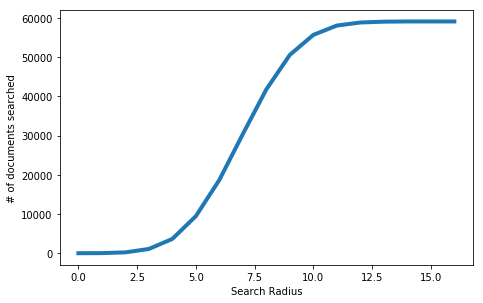

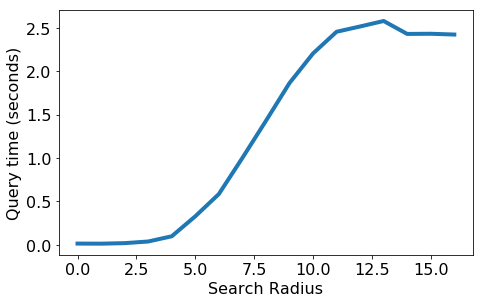

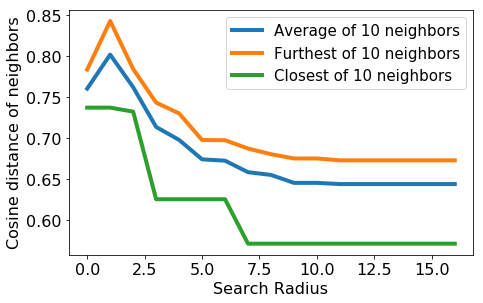

In [56]:
plt.figure(figsize = (7, 4.5))
plt.plot(num_candidates_history, linewidth = 4)
plt.xlabel("Search Radius")
plt.ylabel("# of documents searched")
plt.rcParams.update({"font.size": 16})
plt.tight_layout()

plt.figure(figsize = (7, 4.5))
plt.plot(query_time_history, linewidth = 4)
plt.xlabel("Search Radius")
plt.ylabel("Query time (seconds)")
plt.rcParams.update({"font.size": 16})
plt.tight_layout()

plt.figure(figsize = (7, 4.5))
plt.plot(average_distance_from_query_history, linewidth = 4, label = "Average of 10 neighbors")
plt.plot(max_distance_from_query_history, linewidth = 4, label = "Furthest of 10 neighbors")
plt.plot(min_distance_from_query_history, linewidth = 4, label = "Closest of 10 neighbors")
plt.xlabel("Search Radius")
plt.ylabel("Cosine distance of neighbors")
plt.legend(loc = "best", prop = {"size": 15})
plt.rcParams.update({"font.size": 16})
plt.tight_layout()

Some observations:
* As we increase the search radius, we find more neighbors that are a smaller distance away.
* With increased search radius comes a greater number of documents that have to be searched, Query time is higher as a consequence.
* With sufficiently high search radius, the results of LSH begin to resemble the results of brute-force search.

## Quality metrics for neighbors

The above analysis is limited by the fact that it was run with a single query, namely Barack Obama. We should repeat the analysis for the entirety of data. Iterating over all documents would take a long time, so let us randomly choose 10 documents for our analysis.

For each document, we first compute the true 25 nearest neighbors, and then run LSH multiple times. We look at two metrics:
* Precision@10: How many of the 10 neighbors given by LSH are among the true 25 nearest neighbors?
* Average cosine distance of the neighbors from the query.

Then we run LSH multiple times with different search radii.

In [57]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    nearest_neighbors = pd.DataFrame({"id": np.array(range(num_data_points))})
    nearest_neighbors["distance"] = pairwise_distances(data, vec, metric="cosine").flatten()
    
    
    return nearest_neighbors.sort_values(by=["distance"], ascending=False).iloc[:k]

In [58]:
max_radius = 17
precision = {i:[] for i in xrange(max_radius)}
average_distance = {i:[] for i in xrange(max_radius)}
query_time = {i:[] for i in xrange(max_radius)}

np.random.seed(0)
num_queries = 10

for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace = False)):
    print ("%s / %s" % (i, num_queries))
    ground_truth = brute_force_query(corpus[ix,:], corpus, k=25)["id"]
    
    for r in xrange(1, max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()
        
        query_time[r].append(end-start)
        precision[r].append(len(set(result["id"]) and ground_truth)/10.0)
        average_distance[r].append(result["distance"][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


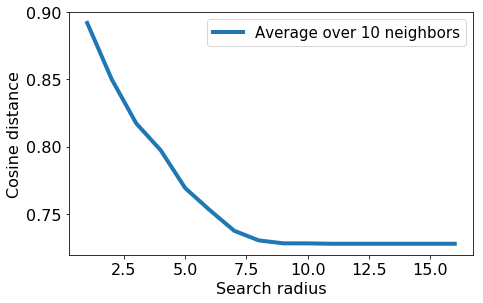

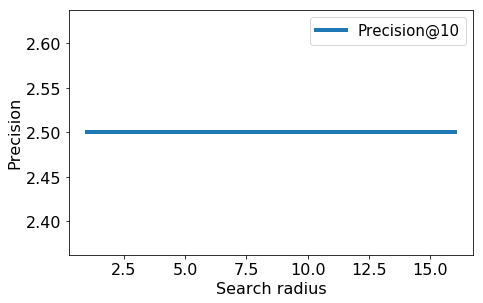

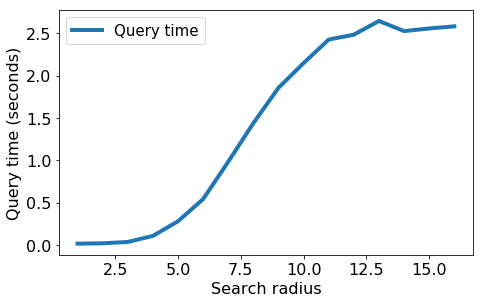

In [59]:
plt.figure(figsize=(7, 4.5))
plt.plot(range(1, 17), [np.mean(average_distance[i]) for i in xrange(1, 17)], linewidth=4, label="Average over 10 neighbors")
plt.xlabel("Search radius")
plt.ylabel("Cosine distance")
plt.legend(loc="best", prop={"size":15})
plt.rcParams.update({"font.size":16})
plt.tight_layout()

plt.figure(figsize=(7, 4.5))
plt.plot(range(1, 17), [np.mean(precision[i]) for i in xrange(1, 17)], linewidth=4, label="Precision@10")
plt.xlabel("Search radius")
plt.ylabel("Precision")
plt.legend(loc="best", prop={"size": 15})
plt.rcParams.update({"font.size": 16})
plt.tight_layout()

plt.figure(figsize=(7, 4.5))
plt.plot(range(1, 17), [np.mean(query_time[i]) for i in xrange(1, 17)], linewidth=4, label="Query time")
plt.xlabel("Search radius")
plt.ylabel("Query time (seconds)")
plt.legend(loc="best", prop={"size": 15})
plt.rcParams.update({"font.size": 16})
plt.tight_layout()

## Effect of number of random vectors

We run LSH with different number of random vectors, ranging from 5 to 20. We fix the search radius to 3.

In [61]:
precision = {i:[] for i in xrange(5, 20)}
average_distance = {i:[] for i in xrange(5, 20)}
query_time = {i:[] for i in xrange(5, 20)}
num_candidates_history = {i:[] for i in xrange(5, 20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix, :], corpus, k=25)["id"])
    
    
for num_vector in xrange(5, 20):
    print ("num_vector = %s" % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix, :], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result["id"]) and ground_truth[ix])/10.0)
        average_distance[num_vector].append(result["distance"][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


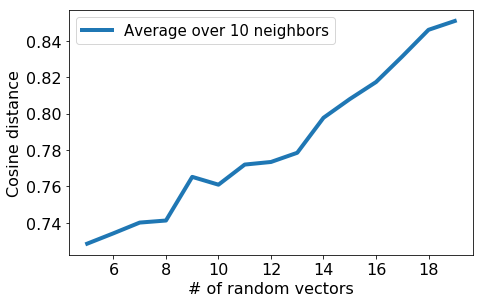

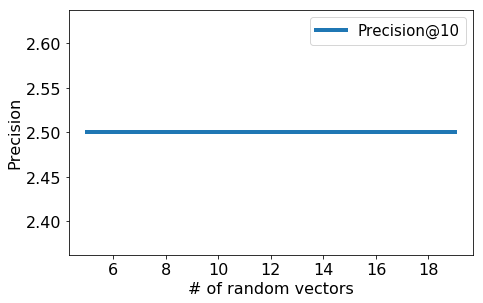

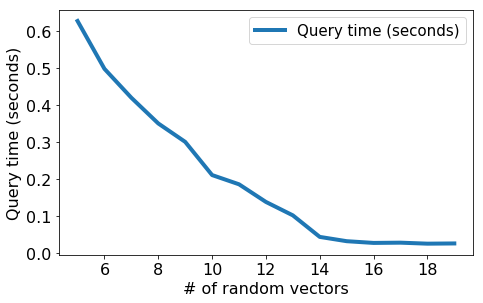

In [64]:
plt.figure(figsize=(7, 4.5))
plt.plot(range(5, 20), [np.mean(average_distance[i]) for i in xrange(5, 20)], linewidth=4, label="Average over 10 neighbors")
plt.xlabel("# of random vectors")
plt.ylabel("Cosine distance")
plt.legend(loc="best", prop={"size": 15})
plt.rcParams.update({"font.size": 16})
plt.tight_layout()

plt.figure(figsize=(7, 4.5))
plt.plot(range(5, 20), [np.mean(precision[i]) for i in xrange(5, 20)], linewidth=4, label="Precision@10")
plt.xlabel("# of random vectors")
plt.ylabel("Precision")
plt.legend(loc="best", prop={"size": 15})
plt.rcParams.update({"font.size": 16})
plt.tight_layout()

plt.figure(figsize=(7, 4.5))
plt.plot(range(5, 20), [np.mean(query_time[i]) for i in xrange(5, 20)], linewidth=4, label="Query time (seconds)")
plt.xlabel("# of random vectors")
plt.ylabel("Query time (seconds)")
plt.legend(loc="best", prop={"size": 15})
plt.rcParams.update({"font.size": 16})
plt.tight_layout()

plt.figure(figsize=(7, 4.5))
plt.plot(range(5, 20), [np.mean(num_candidates_history[i]) for i in xrange(5, 20)], linewidth=4, label="# of documents searched")
plt.xlabel("# of random vectors")
plt.ylabel("# of documents searched")
plt.legend(loc="best", prop={"size": 15})
plt.rcParams.update({"font.size": 16})
plt.tight_layout()